### Trade and Tariff Dataset at the County level

This notebook constructs a trade and county-level tariff data, over time, dataset. **This is a core notebook to the project** so I will try and explain each step clearly. This is one aspect of my code to be scrutinized. It outputs the county-level trade and tariff dataset as a `.parquet` file.

In [1]:
import pandas as pd             # data package
import matplotlib.pyplot as plt # graphics 
import datetime as dt
import numpy as np

import requests, io             # internet and input tools  
import zipfile as zf            # zip file tools 
import os  

#import weightedcalcs as wc
#import numpy as np

import pyarrow as pa
import pyarrow.parquet as pq

### Step 1 Grab and manipulate the county level data for 2017

So we will grab the single file, then adjust it to suit our needs. The needs are to construct county-level employment weights to create a trade exposure metric and tariff metric for each county.

In [2]:
url = "https://data.bls.gov/cew/data/files/2017/csv/2017_annual_singlefile.zip"
# This will read in the annual, single file. It's big, but has all we want...

r = requests.get(url) 

# convert bytes to zip file  
bls_sf = zf.ZipFile(io.BytesIO(r.content)) 
print('Type of zipfile object:', type(bls_sf))

clist = ['area_fips', 'own_code', 'industry_code', 'agglvl_code', 'size_code',
       'year', 'disclosure_code', 'annual_avg_estabs',
       'annual_avg_emplvl', 'total_annual_wages','avg_annual_pay']

df = pd.read_csv(bls_sf.open(bls_sf.namelist()[0]), usecols= clist)

# SHOULD PRESPECIFY TYPES TO 

df.head()


Type of zipfile object: <class 'zipfile.ZipFile'>


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,area_fips,own_code,industry_code,agglvl_code,size_code,year,disclosure_code,annual_avg_estabs,annual_avg_emplvl,total_annual_wages,avg_annual_pay
0,1000,0,10,50,0,2017,NaN,124881,1936819,89088710816,45997
1,1000,1,10,51,0,2017,NaN,1208,53131,4339038631,81668
2,1000,1,102,52,0,2017,NaN,1208,53131,4339038631,81668
3,1000,1,1021,53,0,2017,NaN,610,11173,716001109,64083
4,1000,1,1022,53,0,2017,NaN,2,12,369309,30354


Then the file below cleans stuff up. The most important is the `NAICS_county_level` which selects the NAICS aggregation and then the county aggregation. Website describing this is here:

[https://data.bls.gov/cew/doc/titles/agglevel/agglevel_titles.htm](https://data.bls.gov/cew/doc/titles/agglevel/agglevel_titles.htm)

In [3]:
NAICS_county_level = 75 
# This is the code that will select only counties at the 3 digit NAICS level

df_county = df[df.agglvl_code == NAICS_county_level].copy()

df_county = df_county[df_county.own_code == 5]
# Only grab private stuff

df_county = df_county[(df_county.area_fips.str[0:2] != "72") & (df_county.area_fips.str[0:2] != "78")
              & (df_county.area_fips.str[0:2] != "02") & (df_county.area_fips.str[0:2] != "15")]
#Drop puerto rico, alaska, hawaii...this mayb not be doing what I think it is...as it looks like these guys are there
# Does not matter as analysis is performed withthem, drop them when do the map. 

df_county["sup_ind"] = df_county.industry_code.str[1].astype(int)
# sometimes there are super industries floating around we want to drop them.
# not clear if this matters with the conditioning all ready

df_county = df_county[df_county["sup_ind"] > 0]

df_county.area_fips = df_county.area_fips.astype(str)

df_national = df_county.groupby("industry_code").agg({"annual_avg_emplvl": "sum"})

In [4]:
df_national.reset_index(inplace = True)

In [5]:
df_national.rename({"annual_avg_emplvl":"nat_emplvl"}, axis = 1, inplace = True)

In [6]:
df_national.head()

,industry_code,nat_emplvl
0,111,534697
1,112,228471
2,113,45166
3,114,5005
4,115,352957


Let's compute annual employment. 

In [7]:
df_county.annual_avg_emplvl.sum()

115756851

which matches well with FRED (https://fred.stlouisfed.org/series/USPRIV) in 2017 (off by a couple million)

---
### Step 2 Bring in the trade data

Here we will read in data at the HS6 level, exports to china, over time. 

In [8]:
my_key = "&key=34e40301bda77077e24c859c6c6c0b721ad73fc7"
# This is my key. I'm nice and I have it posted. If you will be doing more with this
# please get your own key!

end_use = "hs?get=E_COMMODITY,CTY_CODE,ALL_VAL_MO,CTY_NAME"

url = "https://api.census.gov/data/timeseries/intltrade/exports/" + end_use 
url = url + my_key + "&time==from+2017-01" + "&COMM_LVL=HS6"

url = url + "&CTY_CODE=5700"

r = requests.get(url) 

df_china_trade = pd.DataFrame(r.json()[1:]) # This then converts it to a dataframe
# Note that the first entry is the labels

df_china_trade.columns = r.json()[0]

df_china_trade.time = pd.to_datetime(df_china_trade.time, format="%Y-%m")
# This is so I can call this correctly...

df_china_trade["china_trade"] = df_china_trade.ALL_VAL_MO.astype(float)

df_china_trade.E_COMMODITY = df_china_trade.E_COMMODITY.astype(str)

df_china_trade.tail(10)

,E_COMMODITY,CTY_CODE,ALL_VAL_MO,CTY_NAME,time,COMM_LVL,CTY_CODE,china_trade
117508,852692,5700,3679920,CHINA,2019-07-01,HS6,5700,3679920.0
117509,852713,5700,166946,CHINA,2019-07-01,HS6,5700,166946.0
117510,852719,5700,0,CHINA,2019-07-01,HS6,5700,0.0
117511,852721,5700,58483,CHINA,2019-07-01,HS6,5700,58483.0
117512,852729,5700,0,CHINA,2019-07-01,HS6,5700,0.0
117513,852791,5700,105003,CHINA,2019-07-01,HS6,5700,105003.0
117514,852799,5700,38370,CHINA,2019-07-01,HS6,5700,38370.0
117515,852842,5700,5395,CHINA,2019-07-01,HS6,5700,5395.0
117516,852849,5700,0,CHINA,2019-07-01,HS6,5700,0.0
117517,852852,5700,1037134,CHINA,2019-07-01,HS6,5700,1037134.0


Now grab **total exports** (not just China) by HS6 level, overtime. 

In [12]:
end_use = "hs?get=E_COMMODITY,ALL_VAL_MO"

url = "https://api.census.gov/data/timeseries/intltrade/exports/"
url = url + end_use + my_key + "&time==from+2017-01" + "&COMM_LVL=HS6"

r = requests.get(url) 

df_all_trade = pd.DataFrame(r.json()[1:]) # This then converts it to a dataframe
# Note that the first entry is the labels

df_all_trade.columns = r.json()[0]

df_all_trade.time = pd.to_datetime(df_all_trade.time, format="%Y-%m")
# This is so I can call this correctly...

df_all_trade["total_trade"] = df_all_trade.ALL_VAL_MO.astype(float)

df_all_trade.E_COMMODITY = df_all_trade.E_COMMODITY.astype(str)

df_all_trade.head(10)

,E_COMMODITY,ALL_VAL_MO,time,COMM_LVL,total_trade
0,284410,2226656,2018-07-01,HS6,2226656.0
1,320720,2910601,2018-07-01,HS6,2910601.0
2,350520,446130,2018-07-01,HS6,446130.0
3,481920,41987912,2018-07-01,HS6,41987912.0
4,020743,11834,2018-06-01,HS6,11834.0
5,320720,7992030,2018-03-01,HS6,7992030.0
6,350520,498935,2018-03-01,HS6,498935.0
7,481920,41538761,2018-03-01,HS6,41538761.0
8,284410,25016,2018-08-01,HS6,25016.0
9,320720,3603564,2018-08-01,HS6,3603564.0


Then combine the china trade and the all trade dataset.

In [13]:
dftrade = df_all_trade.merge(df_china_trade[["E_COMMODITY", "time","china_trade"]], left_on = ["E_COMMODITY", "time"], 
                             right_on = ["E_COMMODITY", "time"], how = "left")

dftrade.set_index("time", inplace = True)

dftrade.drop(["ALL_VAL_MO"], axis = 1, inplace = True)

---
### Step 3 Bring in concordance, create annual and national data set.

Assign Naics codes, create a annual 2017 `df`, create the trade wieghts by naics so we can aggregate the tariffs.

In [14]:
dftrade_17 = dftrade.loc["2017"].groupby("E_COMMODITY").agg({"china_trade":"sum"})

Use the concordance from the US Census to go from HS6 to NAICS. In the code below there are two different approaches to working with the concordance. The latter one makes more sense. Ultimatly does not matter. 

In [16]:
#url = "https://www.census.gov/foreign-trade/reference/codes/concordance/expconcord17.xls"

#df_concordance = pd.read_excel(url, dtype = {"commodity": str, "naics": str})

#df_concordance["hs8"] = df_concordance.commodity.str[0:8]
# truncate down to get the hs8

#df_concordance["hs6"] = df_concordance.commodity.str[0:6]
# truncate down to get the hs6

#df_concordance["naics3"] = df_concordance["naics"].str[0:3]

#dict_concordance = dict(zip(df_concordance.hs6,df_concordance.naics)) 

# This creates a dictionaty from which we can map the hs6 to the naics codes

# Full disclosure. There is an issue with the creation of the dictionary as a unique 
# mapping from hs6 to naics. The notebook ``alt_hs_naics_mapping.ipynb'' provides a complete discussion.
# Ultimatly, this does not matter for the results (relative to the alternative below)

# Below is a fix/alternative approach to creating the mapping from hs6 to naics. In the
# cases where there are multiple naics codes for each hs6 code, it assigns the naics code that is
# associated with the most trade. 

file_path = os.getcwd()

alt_concordance = pq.read_table(file_path + "\\data\\alt_concordance.parquet").to_pandas()

alt_concordance.head()

dict_concordance = dict(zip(alt_concordance.hs6,alt_concordance.naics)) 

Then create this at different levels

In [17]:
dftrade_17["hs6"] = dftrade_17.index

dftrade_17["naics"] = dftrade_17["hs6"].map(dict_concordance)

dftrade_17["naics4"] = dftrade_17["naics"].str[0:4]

dftrade_17["naics3"] = dftrade_17["naics"].str[0:3]

dftrade_17.rename({"china_trade":"2017_china_trade"}, axis = 1, inplace = True)

In [18]:
dftrade_17.head()

,2017_china_trade,hs6,naics,naics4,naics3
E_COMMODITY,,,,,
010121,29098.0,010121,112920,1129,112
010129,27975.0,010129,112920,1129,112
010130,8340.0,010130,112920,1129,112
010190,0.0,010190,112920,1129,112
010221,80280.0,010221,11211X,1121,112


This look good, we have the commodity (as the index), chinese trade, and then different codes to map stuff to. 

Here we will work at the NAICS 3 digit level. The rational for this is that if you go more disaggregate, then confidentialy issues lead to employment at the county-level to be drpoed from the QECW. This is just a simple ``.groupby`` operation. 

In [19]:
dftrade_17_naics3 = dftrade_17.groupby("naics3").agg({"2017_china_trade": "sum"})

In [20]:
dftrade_17_naics3.head()

,2017_china_trade
naics3,
111,1.578543e+10
112,1.066820e+08
113,1.316022e+09
114,1.322142e+09
211,6.731515e+09


Now merge this with the national employment by naics data set.

In [21]:
df_national = df_national.merge(dftrade_17_naics3["2017_china_trade"],
                                left_on = "industry_code", right_index = True, how = "left")

In [22]:
df_national["2017_china_trade"].replace(np.nan, 0, inplace = True)

df_national["trd_wts"] = (df_national["2017_china_trade"]/df_national["2017_china_trade"].sum())

Then check to make sure that the trade weights sum up to one.

In [23]:
df_national.trd_wts.sum()

1.0

In [24]:
dftrade["hs6"] = dftrade.E_COMMODITY

dftrade["naics"] = dftrade["hs6"].map(dict_concordance)

dftrade["naics4"] = dftrade["naics"].str[0:4]

dftrade["naics3"] = dftrade["naics"].str[0:3]

---
### Step 4 Add in the tariff data...

Now here is one of the harder parts.

We want to take the time series data, then layer on the tariff data by product and time. So we will have a big data frame that is (at HS6 level) over time, but each unit of observation has the associated 2017 annual value and the tariff at that date. 

So we will use the `map` function to exploit this.

In [25]:
#tariffs = pd.read_csv("tariff_list_naics.csv", dtype = {"HS-8 code": str,"HS6": str,"naics": str,"naics4": str})

file_path = os.getcwd() + "\\data"

# bring in the tariff data

tariffs = pd.read_csv(file_path + "\\new_tariff_list_max.csv", dtype = {"hs6": str})
# This is the tariff dataset created by updated_tariff_data.ipynb (note the max tariff means taking the largest value
# when going from Chinese hs10 to hs6. This does not matter, if anything gives more conservative resutls)

tariffs.time_of_tariff = pd.to_datetime(tariffs.time_of_tariff, format="%Y-%m")
# make sure the time is there.

tariffs.set_index("time_of_tariff",inplace = True)

In [26]:
tariffs.head()

,hs6,tariff
time_of_tariff,,
2018-01-01,010121,0.0
2018-04-02,010121,0.0
2018-05-01,010121,0.0
2018-07-01,010121,0.0
2018-07-06,010121,0.0


Then we create dictionaries to do the following " you tell me HS, I tell you tariff" by time. 

In [27]:
initial_tariff = dict(zip(tariffs.loc["2018-01-01"].hs6,tariffs.loc["2018-01-01"].tariff)) 
# These are the initial mfn tariffs. We will apply these from 2017 up untill the changes...

tariff_dict_232 = dict(zip(tariffs.loc["2018-04-02"].hs6,tariffs.loc["2018-04-02"].tariff)) 
#These are the section 232 tariffs, response to US steel and aluminum. 

tariff_dict_r1 = dict(zip(tariffs.loc["2018-07-06"].hs6,tariffs.loc["2018-07-06"].tariff)) 
#tariff_dict_r1 = dict(zip(tariffs.loc["2018-07-06"].HS6,tariffs.loc["2018-07-06"].tariff)) 
# This will create a mapping from HS6 to tariff, you tell me HS, I tell you tariff

tariff_dict_r2 = dict(zip(tariffs.loc[dt.datetime(2018,8,23)].hs6,tariffs.loc[dt.datetime(2018,8,23)].tariff)) 

#tariff_dict_r2 = dict(zip(tariffs.loc[dt.datetime(2018,8,23)].HS6,tariffs.loc[dt.datetime(2018,8,23)].tariff)) 
# This will create a mapping from HS6 to tariff, you tell me HS, I tell you tariff, round 2

tariff_dict_r3 = dict(zip(tariffs.loc[dt.datetime(2018,9,24)].hs6,tariffs.loc[dt.datetime(2018,9,24)].tariff))
#tariff_dict_r3 = dict(zip(tariffs.loc[dt.datetime(2018,9,24)].HS6,tariffs.loc[dt.datetime(2018,9,24)].tariff)) 
# This will create a mapping from HS6 to tariff, you tell me HS, I tell you tariff, round 3

tariff_dict_mfn = dict(zip(tariffs.loc["2018-11-01"].hs6,tariffs.loc["2018-11-01"].tariff))
# This reflects mfn adjustments that China made later in the year.

tariff_dict_mfn_2019 = dict(zip(tariffs.loc["2019-01-02"].hs6,tariffs.loc["2019-01-02"].tariff))
# This reflects mfn adjustments and auto adjustment China made at the start of 2019

Then assign the tariffs to the hs6 codes. As mentioned below, the ``.update`` function updates the product code with a new tariff if there is one in the new dictionary.

In [28]:
dftrade["tariff"] = 0

# Then use the map function which will fill in the tariff in the correct places..
# Note the key issue was that the dictionaries were overwritting stuff, hence
# the update...

# Start with the MFN...
dftrade.loc["2017-01":,"tariff"] = dftrade.loc["2017-01":,"hs6"].map(initial_tariff)

#print("done")
# Now update given the 232 response
initial_tariff.update(tariff_dict_232)

dftrade.loc["2018-04":,"tariff"] = dftrade.loc["2018-04":,"hs6"].map(initial_tariff)

#print("done")
# This is the big Phase 1 of the war
initial_tariff.update(tariff_dict_r1)

dftrade.loc["2018-07":,"tariff"] = dftrade.loc["2018-07":,"hs6"].map(initial_tariff)

#print("done")
# Here is phase 2
initial_tariff.update(tariff_dict_r2)

dftrade.loc["2018-09":,"tariff"] = dftrade.loc["2018-09":,"hs6"].map(initial_tariff)

#print("done")
# Here is phase 3
initial_tariff.update(tariff_dict_r3)

dftrade.loc["2018-10":,"tariff"] = dftrade.loc["2018-10":,"hs6"].map(initial_tariff)

#print("done")
# China then adjusts the mfn
initial_tariff.update(tariff_dict_mfn)

dftrade.loc["2018-11":,"tariff"] = dftrade.loc["2018-11":,"hs6"].map(initial_tariff)

#print("done")
# An update on the mfn's
initial_tariff.update(tariff_dict_mfn_2019)

dftrade.loc["2019-01":,"tariff"] = dftrade.loc["2019-01":,"hs6"].map(initial_tariff)

dftrade["tariff"] = dftrade["tariff"].replace(np.nan,0)

dftrade[dftrade["tariff"] == 25].head()

dftrade["2018-08"].head(25)

,E_COMMODITY,COMM_LVL,total_trade,china_trade,hs6,naics,naics4,naics3,tariff
time,,,,,,,,,
2018-08-01,284410,HS6,25016.0,5293.0,284410,325180,3251,325,5.5
2018-08-01,320720,HS6,3603564.0,82647.0,320720,325510,3255,325,5.0
2018-08-01,350520,HS6,548300.0,12420.0,350520,325520,3255,325,20.0
2018-08-01,481920,HS6,45023792.0,84468.0,481920,322212,3222,322,5.0
2018-08-01,851580,HS6,18448513.0,1919133.0,851580,333912,3339,333,8.0
2018-08-01,870870,HS6,115054440.0,508926.0,870870,336211,3362,336,6.0
2018-08-01,020743,HS6,0.0,NaN,020743,311615,3116,311,45.0
2018-08-01,630130,HS6,978072.0,13942.0,630130,314120,3141,314,6.0
2018-08-01,100850,HS6,1311378.0,0.0,100850,111199,1111,111,3.0


This is looking good, not how you can see the tariffs (in august of 2018) hitting in the right places.

Now merge it with the 2017 annual trade data so we can construct trade weighted averages of tariffs....

In [29]:
dftrade = dftrade.merge(dftrade_17["2017_china_trade"], how = "inner", left_on = "E_COMMODITY", right_index = True)

In [30]:
dftrade[dftrade.naics3 == "111"].sort_values(by = ["tariff"], ascending = False)

,E_COMMODITY,COMM_LVL,total_trade,china_trade,hs6,naics,naics4,naics3,tariff,2017_china_trade
time,,,,,,,,,,
2019-02-01,100590,HS6,668165893.0,13309.0,100590,111150,1111,111,90.0,151883243.0
2019-02-01,100119,HS6,12753045.0,NaN,100119,111140,1111,111,90.0,0.0
2018-10-01,100610,HS6,26869283.0,0.0,100610,111160,1111,111,90.0,0.0
2019-03-01,100610,HS6,31912931.0,NaN,100610,111160,1111,111,90.0,0.0
2019-05-01,100610,HS6,58492335.0,NaN,100610,111160,1111,111,90.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2018-02-01,120921,HS6,3964994.0,92250.0,120921,111998,1119,111,0.0,2661790.0
2018-01-01,120921,HS6,5601065.0,NaN,120921,111998,1119,111,0.0,2661790.0
2017-06-01,120921,HS6,12388322.0,447200.0,120921,111998,1119,111,0.0,2661790.0


Looks like we accomplished this task.

Now what we will do is create a function which will make the trade weighted verage of the tariff rates as we aggregate across product codes.

In [31]:
def trd_weighted_avg(df):
    # A function to create the trade weighted average of the tariff rates
    # by round...
    
    trd_w_avg = df["tariff"].multiply(df["2017_china_trade"],axis = 0).sum() 
    # here wuse the 2017 annual values to weight it
    
    trd_w_avg = trd_w_avg / df["2017_china_trade"].sum()
    
    
    foo = {"tariff_trd_w_avg": [trd_w_avg ], 
           "total_trade": df["total_trade"].sum(),
          "china_trade" : df["china_trade"].sum()}
    
    return pd.DataFrame(foo)

Now, `groupby` time and NAICS code (in this case 3), apply the trade weighted function above. Then the resulting data frame should be time, and naics tariffs and the total trade. 

In [32]:
grp = dftrade.groupby(["time","naics3"])

exp_trf_bynaics = grp.apply(trd_weighted_avg)

exp_trf_bynaics = exp_trf_bynaics.droplevel(2)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


In [33]:
exp_trf_bynaics.loc["2018-01"].head(15)

tariff_trd_w_avg   total_trade   china_trade
time       naics3                                              
2018-01-01 111             7.738951  6.044481e+09  1.580785e+09
           112            11.923402  1.404933e+08  1.722368e+06
           113             0.185764  2.036270e+08  8.089366e+07
           114             8.826240  2.423345e+08  5.709779e+07
           211             0.656623  4.646889e+09  9.177222e+08
           212             1.669023  1.505520e+09  1.383602e+08
           311            11.732877  5.094319e+09  2.287681e+08
           312            10.654408  6.084754e+08  8.101847e+06
           313             9.065944  7.326278e+08  2.913878e+07
           314             9.958472  2.601312e+08  4.274722e+06
           315            15.546809  4.048624e+08  7.298691e+06
           316             9.889121  2.988748e+08  3.691118e+07
           321             0.180372  5.539431e+08  1.309546e+08
           322             2.215004  2.021641e+09  2.241574e+08
           323             3.078089  4.107334e+08  1.171687e+07

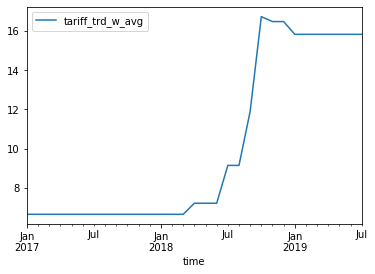

In [34]:
exp_trf_bynaics.groupby(["time"]).agg({"tariff_trd_w_avg": "mean"}).plot()

This simple plot looks a lot like the Bowen figures. Note that the dip is all about China changing their MFN tariffs in (what appears to be) certain consumer orinted catagories as Bowen point out. So clothing stuff falls, while they are hammering the ag. products. 

Looks like we accomplished this task. Just a couple of things to clean up then we are ready to move onto the next step. 

In [35]:
exp_trf_bynaics["time"] = exp_trf_bynaics.index.get_level_values(0)

In [36]:
exp_trf_bynaics = exp_trf_bynaics.droplevel(level=0)

In [37]:
exp_trf_bynaics.loc["111"]

,tariff_trd_w_avg,total_trade,china_trade,time
naics3,,,,
111,7.738953,6.619171e+09,2.110695e+09,2017-01-01
111,7.738953,6.084644e+09,1.366946e+09,2017-02-01
111,7.738953,6.301076e+09,9.569031e+08,2017-03-01
111,7.738953,5.227715e+09,5.743821e+08,2017-04-01
111,7.738953,4.828126e+09,4.453909e+08,2017-05-01
111,7.738953,4.631361e+09,3.614239e+08,2017-06-01
111,7.738953,4.734344e+09,5.628932e+08,2017-07-01
111,7.738953,4.361836e+09,7.076222e+08,2017-08-01
111,7.738953,4.930351e+09,1.280538e+09,2017-09-01


---

### Step 3 Merge trade data with the county data

This is the most time consuming step (interms of compuation time). So start with the county data set, `groupby` county, then apply a function which will create (i) time varying exports (which are constructed with the 2017 weightes) and (ii) time varying tariffs (also constructed using the 2017) weights. 

The final want is a big dataframe that has county, time, export exposure and tariff exposure. 

In [38]:
grp = df_county.groupby("area_fips")

# This creates groups at the county level.

In [39]:
# Let's just look at one of the groups...

grp.get_group("1001").head()

,area_fips,own_code,industry_code,agglvl_code,size_code,year,disclosure_code,annual_avg_estabs,annual_avg_emplvl,total_annual_wages,avg_annual_pay,sup_ind
3016,1001,5,111,75,0,2017,N,4,0,0,0,1
3026,1001,5,112,75,0,2017,NaN,3,27,848146,31905,1
3033,1001,5,113,75,0,2017,NaN,4,36,2901165,80032,1
3040,1001,5,115,75,0,2017,NaN,9,27,2007731,74132,1
3052,1001,5,212,75,0,2017,N,4,0,0,0,1


Below are the two key functions that deliver this. Basically it does the following: 

- Take a group at county level, merge it with the national level data set, so the resulting `df` has the county and nation.

- Create the weights. 

- Then merge it with the exports, this will now be a df with exports varying over time, but with the fixed weights associated with each entry.

- Then aggregate the national exports by NAICS by the county level weights, giving a county level time series of exports.

---

**Updates**

- The tariff measure does the following: fix a county, take employment in industry $i$ and divide by total county employment, then sum up tariffs across industries with the weights being the county level share. The idea here is if all employment in a county is soy, then the "effective" tariff that the county faces is the soy tariff.

In equation terms: here $c$ is county, $s$ is industry, $n$, below is nation.

$\tau_{c,t} = \sum_{s\in S}\frac{L_{c,s}}{L_{c,S}} \tau_{s,t}$

Note that below, I make one further adjustment to make sure that $L_{c,S}$ is for all employment, not just the sum across $L_{c,s}$


- The export measure: What am I doing: take a county's employment in industry $i$ and divide by **national** level employment in industry $i$. Then a "county's" exports is the the sum across industries, weighted by the county's share of national employment in each industry. The idea here is, if a county's has all national level employment in an industry, all that industries exports will be assigned to that county.

$\mbox{EX}_{c,t} = \frac{1}{L_{c,S,2017}}\sum_{s\in S}\frac{L_{c,s,2017}}{L_{n,s,2017}} \mbox{EX}_{s,t}$

and then I divide by total employment in the county to have a county per worker measure. This is done for exports to China and then export in total. Note that below, I make one further adjustment to make sure that $L_{c,S}$ is for all employment, not just the sum across $L_{c,s}$




In [40]:
def create_trade_weights(df):
    # Takes in the county groupings and will return, for each county, a time series of export
    # exposure, tariffs, and other statistics. 

    new_df = df.merge(df_national[["nat_emplvl",
                                   "industry_code", "trd_wts"]],
                                  how = "outer", left_on = "industry_code", right_on = "industry_code")
    # Merge the nation with the county, why, we want to make sure all the naics codes are lined up properly
        
    new_df["emp_wts"] = (new_df.annual_avg_emplvl/new_df.nat_emplvl)
     
    # create the weights...
        
    foo_df = exp_trf_bynaics.merge(new_df[["emp_wts","trd_wts",
                                           "industry_code",
                                          "annual_avg_emplvl"]], left_index = True, right_on = "industry_code")  
    
    # Now each weight is for a NAICS code, we will merge it with the export trade data set, so for all naics, all time...
    # This is a big df whith all trade data and then the county's weights for each naics code
    
    foo_grp = foo_df.groupby("time")
    
    # group by time. 
    
    foo = foo_grp.apply(trade_by_naics)
    
    # Then for each time gropuing, we aggregate across the naics codes according to the weights above.
    
    foo = foo.droplevel(1)
    
    foo["fips"] = df["area_fips"].astype(str).iloc[0]
    
    # some cleaning of the df
    
    foo["total_employment"] = new_df.annual_avg_emplvl.sum()
    
    # get total employment.
    
    return pd.DataFrame(foo)
    

In [41]:
def trade_by_naics(df):
    # Simple function just to test about aggregation 

    china_exp_pc = (1/df["annual_avg_emplvl"].sum())*(df["china_trade"]*df["emp_wts"]).sum()
    
    total_exp_pc = (1/df["annual_avg_emplvl"].sum())*(df["total_trade"]*df["emp_wts"]).sum()
    # the first term multiplies trade by the county's share of national level employment
    # then the outside term divides by number of workers in a county. 
    
    #tariff_nwt_pc = (1/df["annual_avg_emplvl"].sum())*(df["tariff_trd_w_avg"]*df["emp_wts"]).sum()
    # This is the measure that makes most sense, need to justify it...
    tariff =  ((df["annual_avg_emplvl"]*df["tariff_trd_w_avg"])/df["annual_avg_emplvl"].sum()).sum()
    # local employment share weighted tariff. So if all guys are in area are working in soy,
    # then they are facing the soybean tariff....
    
    foo = {"total_exp_pc": [total_exp_pc],
          "china_exp_pc": [china_exp_pc],
           "tariff": [tariff],
          "emplvl_2017": df["annual_avg_emplvl"].sum()}

    return pd.DataFrame(foo)

Then apply the function to the county groups

In [42]:
trade_county = grp.apply(create_trade_weights)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


And we are done and output the file to where we want it

In [43]:
trade_county.sort_values(by = ["tariff","emplvl_2017"], ascending = False).head(25)

total_exp_pc  china_exp_pc     tariff  emplvl_2017  \
area_fips time                                                             
29133     2019-03-01  10871.646688   1207.755065  32.843841        373.0   
          2019-04-01   9720.978332    682.462529  32.843841        373.0   
          2019-05-01   9564.543414   1239.255085  32.843841        373.0   
28143     2019-03-01  10871.646688   1207.755065  32.843841        311.0   
          2019-04-01   9720.978332    682.462529  32.843841        311.0   
          2019-05-01   9564.543414   1239.255085  32.843841        311.0   
28011     2019-03-01  10871.646688   1207.755065  32.843841        286.0   
          2019-04-01   9720.978332    682.462529  32.843841        286.0   
          2019-05-01   9564.543414   1239.255085  32.843841        286.0   
28027     2019-03-01  10871.646688   1207.755065  32.843841        275.0   
          2019-04-01   9720.978332    682.462529  32.843841        275.0   
          2019-05-01   9564.543414   1239.255085  32.843841        275.0   
4012      2019-03-01  10871.646688   1207.755065  32.843841        258.0   
          2019-04-01   9720.978332    682.462529  32.843841        258.0   
          2019-05-01   9564.543414   1239.255085  32.843841        258.0   
29143     2019-03-01  10871.646688   1207.755065  32.843841        227.0   
          2019-04-01   9720.978332    682.462529  32.843841        227.0   
          2019-05-01   9564.543414   1239.255085  32.843841        227.0   
53043     2019-03-01  10871.646688   1207.755065  32.843841        227.0   
          2019-04-01   9720.978332    682.462529  32.843841        227.0   
          2019-05-01   9564.543414   1239.255085  32.843841        227.0   
13101     2019-03-01  10871.646688   1207.755065  32.843841        216.0   
          2019-04-01   9720.978332    682.462529  32.843841        216.0   
          2019-05-01   9564.543414   1239.255085  32.843841        216.0   
8109      2019-03-01  10871.646688   1207.755065  32.843841        216.0   

                       fips  total_employment  
area_fips time                                 
29133     2019-03-01  29133            1890.0  
          2019-04-01  29133            1890.0  
          2019-05-01  29133            1890.0  
28143     2019-03-01  28143            5813.0  
          2019-04-01  28143            5813.0  
          2019-05-01  28143            5813.0  
28011     2019-03-01  28011            5285.0  
          2019-04-01  28011            5285.0  
          2019-05-01  28011            5285.0  
28027     2019-03-01  28027            4471.0  
          2019-04-01  28027            4471.0  
          2019-05-01  28027            4471.0  
4012      2019-03-01   4012            2180.0  
          2019-04-01   4012            2180.0  
          2019-05-01   4012            2180.0  
29143     2019-03-01  29143            3487.0  
          2019-04-01  29143            3487.0  
          2019-05-01  29143            3487.0  
53043     2019-03-01  53043            1132.0  
          2019-04-01  53043            1132.0  
          2019-05-01  53043            1132.0  
13101     2019-03-01  13101             411.0  
          2019-04-01  13101             411.0  
          2019-05-01  13101             411.0  
8109      2019-03-01   8109             699.0

**One more adjustment.** Notice that in the function, when we are merging, we are droping all the NAICS codes without trade. So these measures (total trade, china trade, and tariffs) are only conditional on being traded. This only matters in so far as the denominator, the ``df["annual_avg_emplvl"].sum()`` is concerned. 

To make the adjustment then, we multiply the employment measure in the denominator and then divide through by the ``total_employment`` measure. 

In [44]:
trade_county["tariff"] = (trade_county["emplvl_2017"]/
                              trade_county["total_employment"])*trade_county["tariff"]

trade_county["china_exp_pc"] = (trade_county["emplvl_2017"]/
                                    trade_county["total_employment"])*trade_county["china_exp_pc"]

trade_county["total_exp_pc"] = (trade_county["emplvl_2017"]/
                                    trade_county["total_employment"])*trade_county["total_exp_pc"]

In [45]:
os.getcwd()

'C:\\github\\consumption_and_tradewar'

In [46]:
file_path = os.getcwd() + "\\data"+ "\\total_trade_data.parquet"

pq.write_table(pa.Table.from_pandas(trade_county.reset_index()), file_path)

In [47]:
trade_county.sort_values(by = ["tariff","emplvl_2017"], ascending = False).head(50)

total_exp_pc  china_exp_pc     tariff  emplvl_2017  \
area_fips time                                                             
53023     2019-03-01  10871.646688   1207.755065  32.843841         37.0   
          2019-04-01   9720.978332    682.462529  32.843841         37.0   
          2019-05-01   9564.543414   1239.255085  32.843841         37.0   
28055     2019-03-01  10871.646688   1207.755065  32.843841         21.0   
          2019-04-01   9720.978332    682.462529  32.843841         21.0   
          2019-05-01   9564.543414   1239.255085  32.843841         21.0   
53023     2019-02-01  10440.790650   1605.624408  32.843840         37.0   
28055     2019-02-01  10440.790650   1605.624408  32.843840         21.0   
53023     2018-10-01  11077.880433    341.748327  32.843688         37.0   
          2018-11-01  11098.423631    245.768800  32.843688         37.0   
          2018-12-01  10359.291167    325.183876  32.843688         37.0   
          2019-06-01   9071.415764   1534.950789  32.843688         37.0   
          2019-07-01   9002.619207   1584.548413  32.843688         37.0   
28055     2018-10-01  11077.880433    341.748327  32.843688         21.0   
          2018-11-01  11098.423631    245.768800  32.843688         21.0   
          2018-12-01  10359.291167    325.183876  32.843688         21.0   
          2019-06-01   9071.415764   1534.950789  32.843688         21.0   
          2019-07-01   9002.619207   1584.548413  32.843688         21.0   
53023     2019-01-01  10738.715609   1055.003978  32.842474         37.0   
28055     2019-01-01  10738.715609   1055.003978  32.842474         21.0   
53023     2018-07-01   9751.343396    363.359785  32.810320         37.0   
          2018-08-01   8796.029329    250.216820  32.810320         37.0   
          2018-09-01   8501.304814    157.381511  32.810320         37.0   
28055     2018-07-01   9751.343396    363.359785  32.810320         21.0   
          2018-08-01   8796.029329    250.216820  32.810320         21.0   
          2018-09-01   8501.304814    157.381511  32.810320         21.0   
48229     2019-03-01   9958.760325   1106.340518  30.085961        120.0   
          2019-04-01   8904.712976    625.156515  30.085961        120.0   
          2019-05-01   8761.413815   1135.195497  30.085961        120.0   
          2019-02-01   9564.083038   1470.800984  30.085960        120.0   
          2018-10-01  10147.676733    313.051902  30.085821        120.0   
          2018-11-01  10166.494929    225.131725  30.085821        120.0   
          2018-12-01   9489.427023    297.878360  30.085821        120.0   
          2019-06-01   8309.693830   1406.061791  30.085821        120.0   
          2019-07-01   8246.674083   1451.494730  30.085821        120.0   
          2019-01-01   9836.991398    966.415858  30.084709        120.0   
          2018-07-01   8932.528302    332.848658  30.055255        120.0   
          2018-08-01   8057.431446    229.206247  30.055255        120.0   
          2018-09-01   7787.454791    144.166270  30.055255        120.0   
20199     2019-03-01   8530.061247    947.623205  25.769783         51.0   
          2019-04-01   7627.229153    535.470600  25.769783         51.0   
          2019-05-01   7504.487910    972.338605  25.769783         51.0   
          2019-02-01   8192.004971   1259.797612  25.769782         51.0   
          2018-10-01   8691.875417    268.140995  25.769663         51.0   
          2018-11-01   8707.993926    192.833981  25.769663         51.0   
          2018-12-01   8128.059223    255.144272  25.769663         51.0   
          2019-06-01   7117.572369   1204.346004  25.769663         51.0   
          2019-07-01   7063.593531   1243.261063  25.769663         51.0   
          2019-01-01   8425.761478    827.772352  25.768711         51.0   
          2018-07-01   7651.054049    285.097678  25.743482         51.0   

                       fips  total_employment  
area_fips time       

In [48]:
exposure = pd.qcut(trade_county.xs('2018-12-1', level=1).tariff, 4 ,labels = False)

In [49]:
most_exposed = exposure[exposure == 3].index.tolist()

trade_county.loc[most_exposed].xs('2018-12-1', level=1).tariff.mean()

6.4691811550724125